In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, confusion_matrix, 
                           classification_report, mean_squared_error)
from sklearn.decomposition import PCA
import joblib
import json
%matplotlib inline

In [21]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

In [22]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the built-in iris dataset
iris = load_iris()

feature_names = iris.feature_names
target_names = iris.target_names

# Convert to DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['species'] = df['target'].map({i: iris.target_names[i] for i in range(len(iris.target_names))})

print(df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  


In [23]:
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Features: {feature_names}")
print(f"Target Classes: {list(target_names)}")

Dataset Info:
Shape: (150, 6)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Classes: ['setosa', 'versicolor', 'virginica']


In [24]:
# Missing values
print("🔍 Missing Values:")
print(df.isnull().sum())

🔍 Missing Values:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
species              0
dtype: int64


In [25]:
# Statistics
display(df.drop('target', axis=1).describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


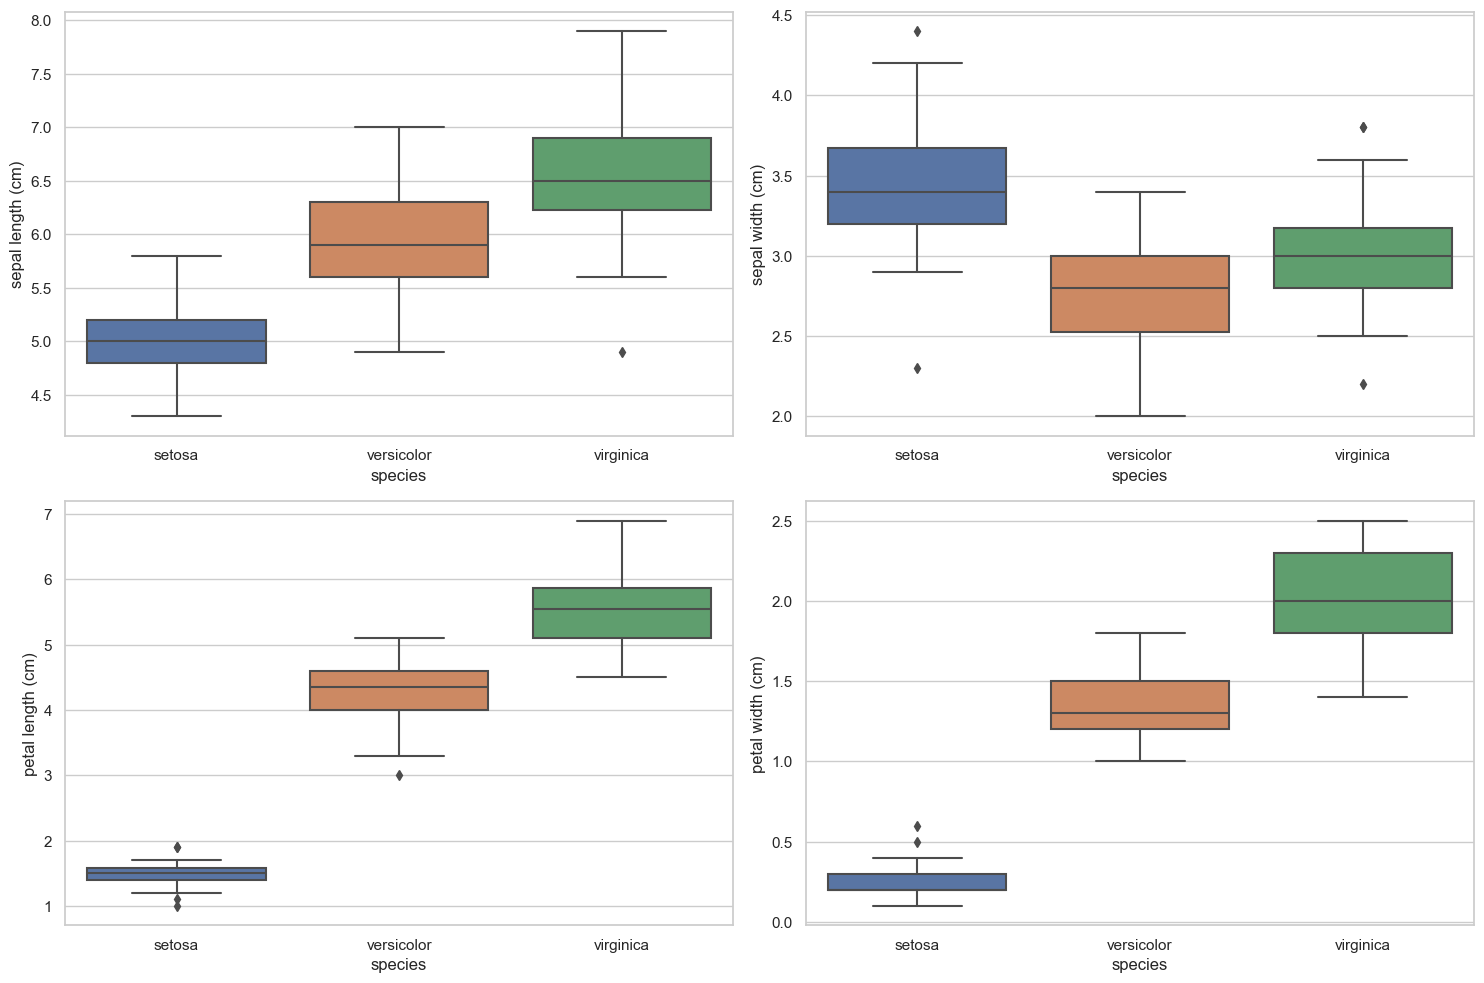

In [26]:
# Boxplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, feature in enumerate(feature_names):
    sns.boxplot(x='species', y=feature, data=df, ax=axes[i//2, i%2])
plt.tight_layout()
plt.show()

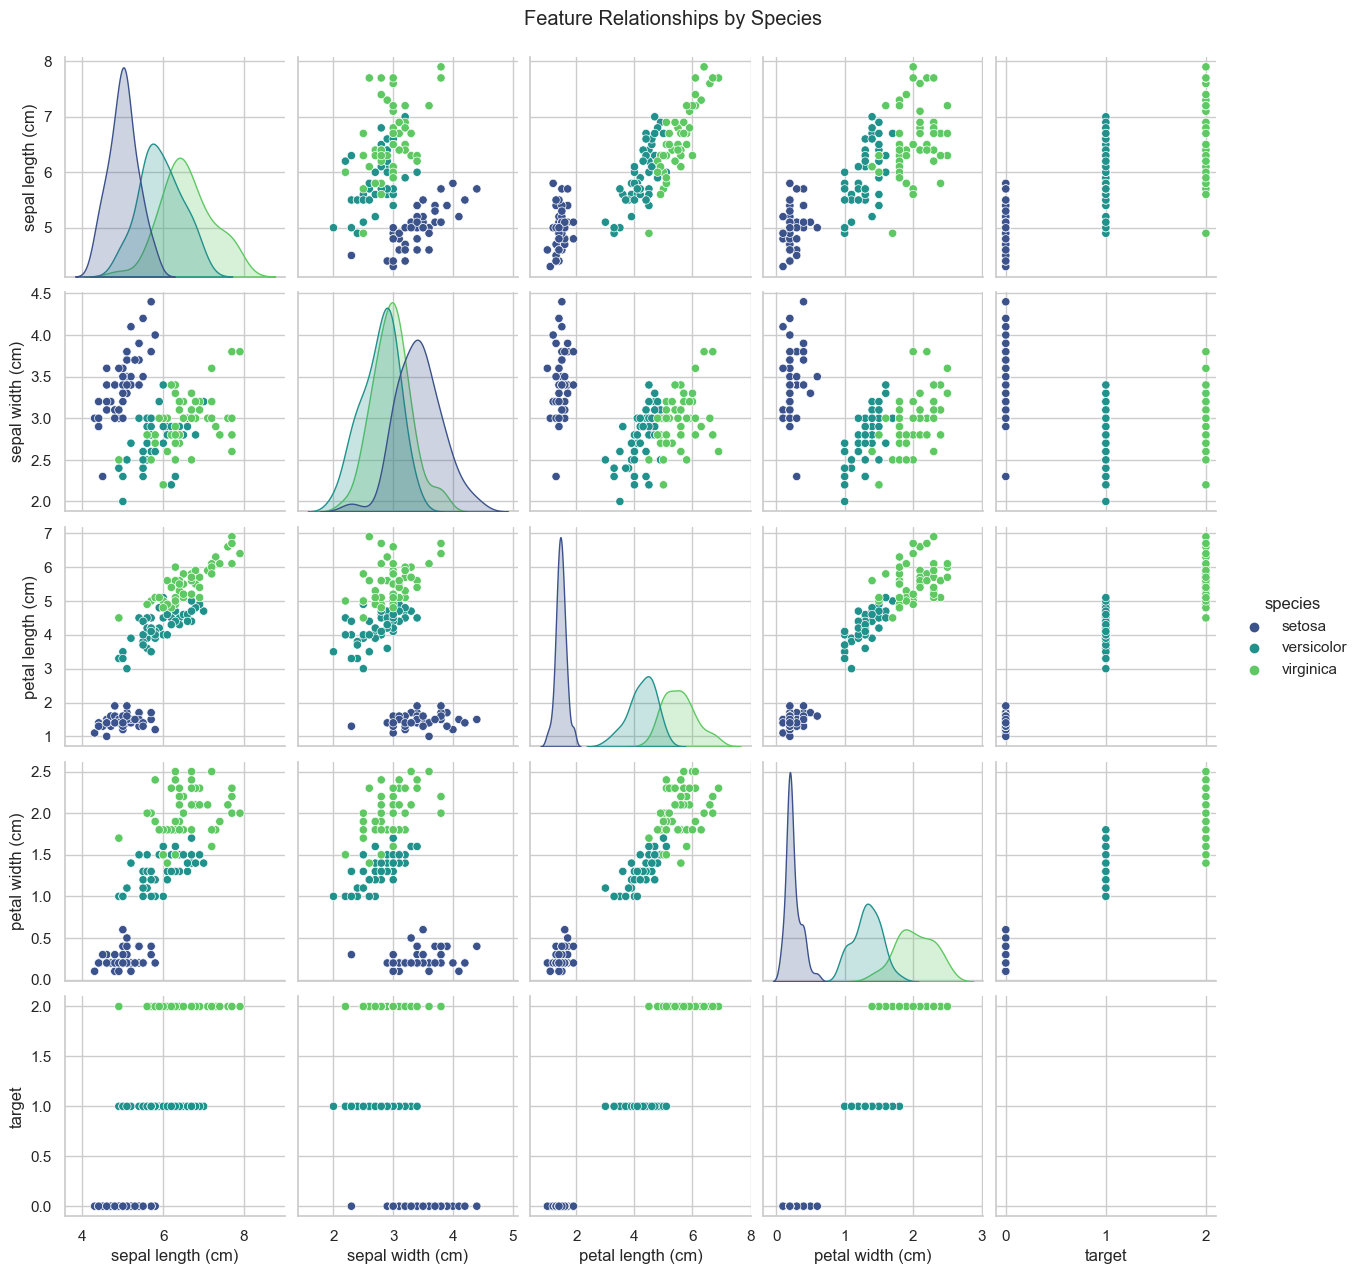

In [27]:
# Pairplot
sns.pairplot(df, hue='species', palette='viridis', diag_kind='kde')
plt.suptitle("Feature Relationships by Species", y=1.02)
plt.show()

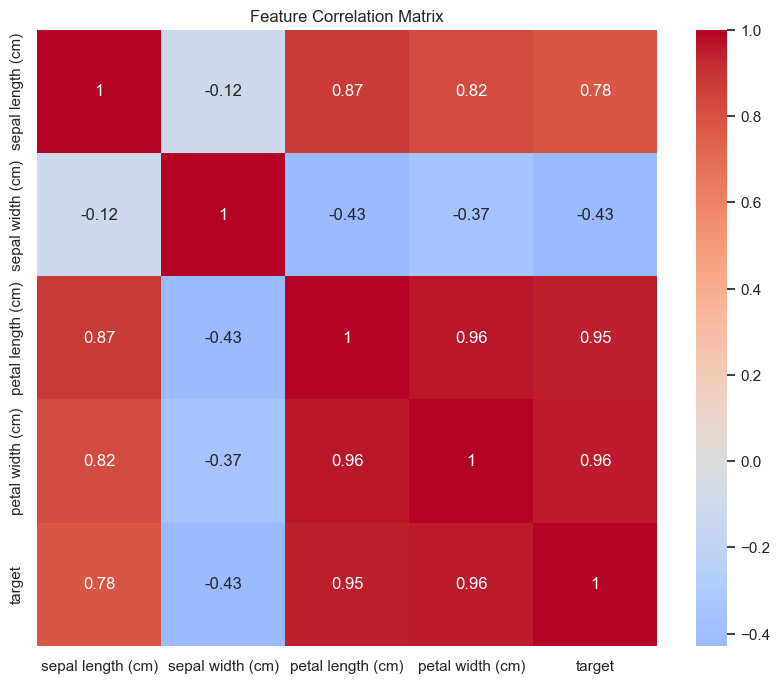

In [28]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

Data Preprocessing


In [29]:
X = df.drop(['target', 'species'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 120
Test set size: 30


Model Training & Cross-Validation


In [31]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

model.fit(X_train_scaled, y_train)

CV Accuracy Scores: [0.95833333 1.         0.95833333 0.91666667 0.91666667]
Mean CV Accuracy: 0.9500 ± 0.0312


RandomForestClassifier(random_state=42)

Model Evaluation (with RMSE)


In [32]:
y_pred = model.predict(X_test_scaled)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
}
print(classification_report(y_test, y_pred, target_names=target_names))
print(json.dumps(metrics, indent=4))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

{
    "Accuracy": 0.9,
    "Precision": 0.9023569023569024,
    "Recall": 0.9,
    "F1 Score": 0.8997493734335839,
    "RMSE": 0.31622776601683794
}


In [33]:
import json
import os

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/feature_names.json", "w") as f:
    json.dump(iris.feature_names, f)

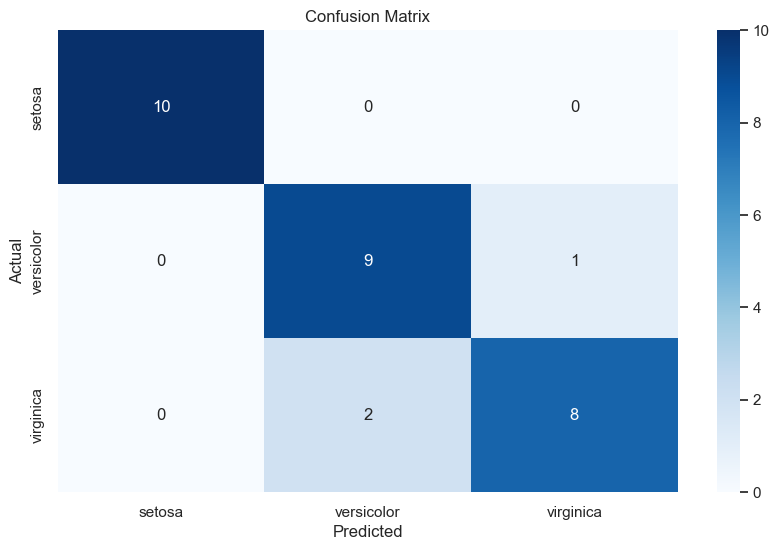

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred),
           annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

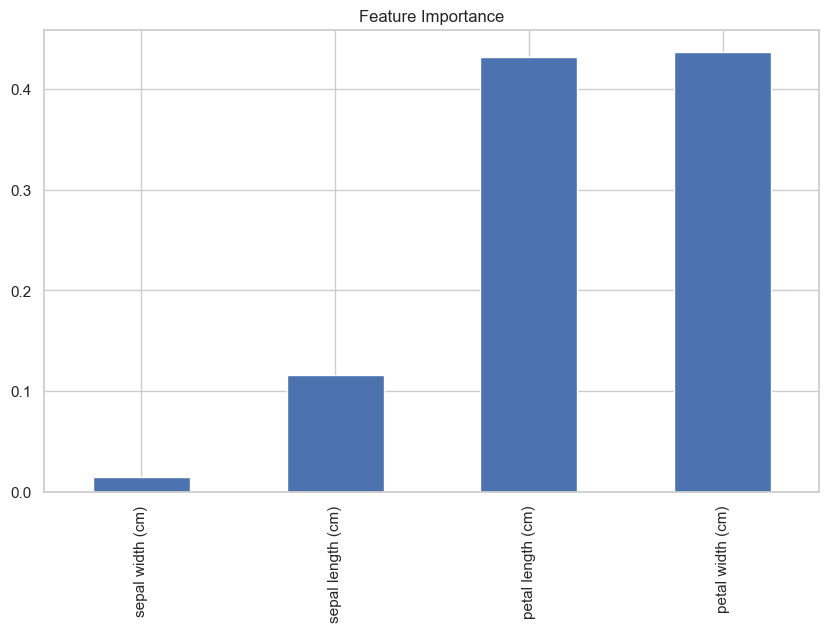

In [35]:
importance = pd.Series(model.feature_importances_, index=feature_names)
importance.sort_values().plot(kind='bar')
plt.title("Feature Importance")
plt.show()

PCA Decision Boundary Visualization

In [36]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
model_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

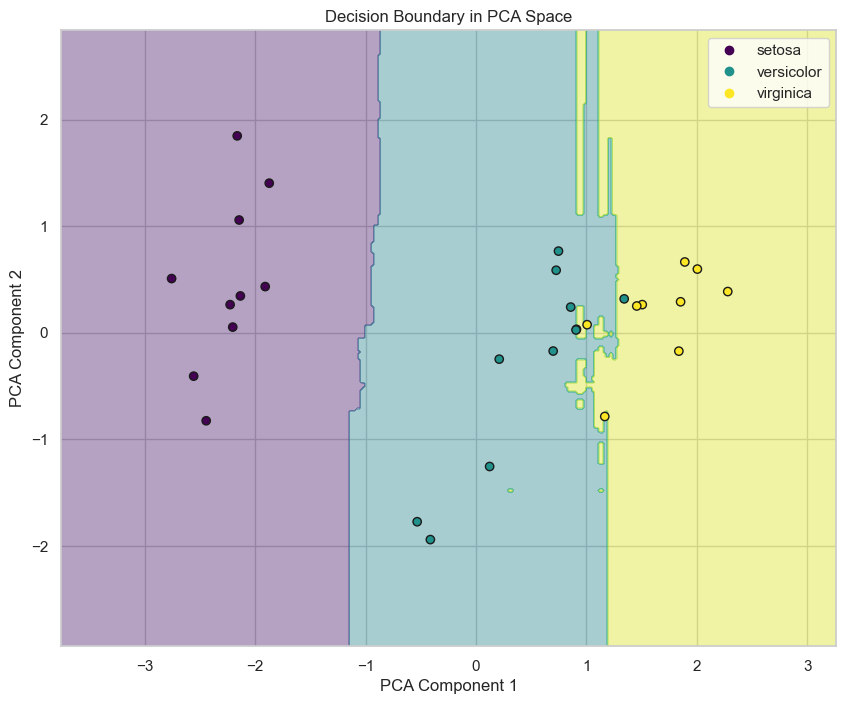

In [37]:
h = 0.02
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1],
                      c=y_test, edgecolor='k', cmap='viridis')
plt.title("Decision Boundary in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names))
plt.show()

In [38]:
import os
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/iris_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!


In [39]:
import os 
os.makedirs("artifacts", exist_ok=True)
class_names = [
    "setosa",
    "versicolor",
    "virginica"
]
with open("artifacts/class_names.json", "w") as f:
    json.dump(class_names, f)